In [6]:
#https://www.datatechnotes.com/2024/04/sequence-prediction-with-lstm-model-in.html
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
from torch.utils import data

In [26]:
from scripts_stock.analysis.fuquan_data.get_data_sql import FGetDataSql 
from scripts_stock.utils.common import CommonScript


conn = CommonScript.connect_to_db("test.db")
stock_index = "601398"
date_cut = "2022-01-01"
input_sql_str = FGetDataSql.get_data_sql_str_before_years(stock_index,date_cut)
df1 = pd.read_sql_query(input_sql_str, conn)
df1.head(3)

,date,open,close,high,low,stock_index,update_time
0,2022-01-04,3.74,3.77,3.77,3.73,601398,2024-09-24 00:54:17.021450
1,2022-01-05,3.76,3.81,3.82,3.75,601398,2024-09-24 00:54:17.021450
2,2022-01-06,3.80,3.80,3.83,3.78,601398,2024-09-24 00:54:17.021450


In [50]:
df1.shape[0]*0.4

264.0

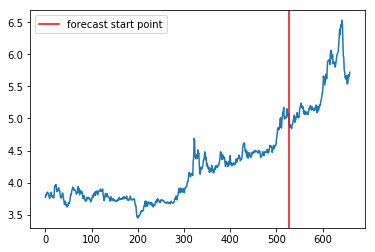

In [52]:
# Define parameters
step_size = 30
N = 800
forecast_start = int(df1.shape[0]*0.8)

# Generate data
t = np.arange(0, N)
x = np.sin(0.02 * t) + 2 * np.random.rand(N)
df = pd.DataFrame(x)

df = df1[["close"]]
# Plot data
plt.plot(df)
plt.axvline(df.index[forecast_start], c="r", label="forecast start point")
plt.legend()
plt.show()

In [62]:
a1 = np.concatenate((trainX,trainX),axis=0)
a1.shape

(996, 1, 30)

In [53]:
# Convert data into sequence and label with given length
def create_labels(data, step):
    X = np.array([data[i:i+step] for i in range(len(data) - step)])
    y = np.array(data[step:])
    return X, y

In [63]:
values

array([[3.77],
       [3.81],
       [3.8 ],
       [3.84],
       [3.85],
       [3.85],
       [3.82],
       [3.83],
       [3.78],
       [3.75],
       [3.79],
       [3.8 ],
       [3.85],
       [3.8 ],
       [3.8 ],
       [3.77],
       [3.79],
       [3.78],
       [3.76],
       [3.84],
       [3.95],
       [3.94],
       [3.96],
       [3.97],
       [3.9 ],
       [3.86],
       [3.88],
       [3.88],
       [3.91],
       [3.92],
       [3.88],
       [3.87],
       [3.8 ],
       [3.77],
       [3.76],
       [3.78],
       [3.8 ],
       [3.84],
       [3.82],
       [3.75],
       [3.72],
       [3.66],
       [3.66],
       [3.71],
       [3.69],
       [3.64],
       [3.65],
       [3.62],
       [3.65],
       [3.64],
       [3.69],
       [3.67],
       [3.68],
       [3.72],
       [3.79],
       [3.82],
       [3.81],
       [3.87],
       [3.89],
       [3.93],
       [3.92],
       [3.91],
       [3.88],
       [3.88],
       [3.89],
       [3.87],
       [3.

In [54]:
# Prepare data for training and testing
values = df.values
train, test = values[:forecast_start, :], values[forecast_start:N, :]

# generate sequence data
trainX, trainY = create_labels(train, step_size)
print(trainX.shape,trainY.shape)
testX, testY = create_labels(test, step_size)

# Reshape data for LSTM input
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

# Convert data to PyTorch tensors
trainX_tens = torch.tensor(trainX, dtype=torch.float32)
trainY_tens = torch.tensor(trainY, dtype=torch.float32)
testX_tens = torch.tensor(testX, dtype=torch.float32)
testY_tens = torch.tensor(testY, dtype=torch.float32)

# Create DataLoader for training
train_dataset = torch.utils.data.TensorDataset(trainX_tens, trainY_tens)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64)

(498, 30, 1) (498, 1)


In [55]:
# Define LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])  # Take the last time step's output
        return out

In [56]:
# Hyperparameters
input_size = step_size
hidden_size = 128
output_size = 1
epochs = 100
learning_rate = 0.0001
 
# Instantiate LSTM model
model = LSTMModel(input_size=input_size, hidden_size=hidden_size, output_size=output_size)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)



In [57]:
# Train the model
for epoch in range(epochs):
    model.train()
    for batch_X, batch_Y in train_loader:
        optimizer.zero_grad()  # Clears the gradients of all optimized parameters.
        output = model(batch_X)

        # Computes the loss between the model predictions and the ground
        # truth labels for the current mini-batch.
        loss = criterion(output, batch_Y)

        # Computes gradients of the loss with respect to model parameters.
        loss.backward()

        # Updates model parameters based on the computed gradients using
        # the specified optimization algorithm.
        optimizer.step()

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.4f}')


Epoch [10/100], Loss: 11.1678
Epoch [20/100], Loss: 2.8400
Epoch [30/100], Loss: 0.6492
Epoch [40/100], Loss: 0.2923
Epoch [50/100], Loss: 0.2410
Epoch [60/100], Loss: 0.2328
Epoch [70/100], Loss: 0.2291
Epoch [80/100], Loss: 0.2254
Epoch [90/100], Loss: 0.2215
Epoch [100/100], Loss: 0.2172


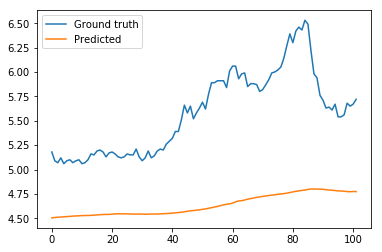

In [58]:
# Evaluation
with torch.no_grad():
    model.eval()
    testPredict = model(testX_tens)

# Plot results
index = range(len(testY))
plt.plot(index, testY, label="Ground truth")
plt.plot(index, testPredict.numpy(), label="Predicted")
plt.legend()
plt.show()